In [23]:
from src.distance_measures import analyse_video, analyse_image
from src.gaussian_noise import generate_noise_array, generate_noise
from src.preprocessing import process_image, process_video
from src.gradient_descent import find_default_params
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import label2rgb
from tqdm import tqdm

### Hyperparameters

In [24]:
size = 400
skip_size=24
L=50
im_thresh = 0.3
noise_thresh = 0.2
smooth = 2.4

epochs = 20
h = 0.01
learning_rate = 0.01
w_list= [1, 0.2, 0.04, 0.008, 0]

In [25]:
path = 'images/cheese_gel.avi'

im = process_video(path, threshold=im_thresh, size=size, smooth=1, skip_size=skip_size)
# shortening the video
im = im[:7]

### Gradient Descent

In [26]:
def model(thresh, smooth):
    noise = generate_noise_array(size=size, threshold=thresh, smooth=smooth, amount=2)
    F, G = analyse_video(noise, L=L)
    return np.mean([i / j for i, j in zip(F, G)], axis=0)

def loss_fn(y, thresh, smooth, pthresh, psmooth, w):
    return np.sum((model(thresh, smooth) - y)**2) + w*((thresh - pthresh)**2 + 0.5*(smooth - psmooth)**2)

In [ ]:
im_thresholds= np.linspace(0.1,0.5,4)
noise_thresholds=np.linspace(0.2,0.4,4)
lrates = np.linspace(0.02,0.06,4)
hrates = np.linspace(0.02,0.05,4)
p=0
for aa,bb,lrate,hrate in (zip(im_thresholds,noise_thresholds,lrates,hrates)):
    print(aa,bb,lrate,hrate) 
    size = 400
    skip_size=24
    L=50
    im_thresh = aa
    noise_thresh = bb
    smooth = 2.4

    epochs = 20
    h = hrate
    learning_rate = lrate
    w_list= [1, 0.2, 0.04, 0.008, 0]



    loss_all = []
    params = []
    prior_smooth, prior_thresh = find_default_params(im[0])

    for frame in tqdm(im):
        F, G = analyse_image(frame, L=L)
        y = F/G
        loss_list = []
        for w in w_list:
            for i in range(epochs):
                loss = loss_fn(y, noise_thresh, smooth, prior_thresh, prior_smooth, w)
                grad1 = (loss_fn(y, noise_thresh+h, smooth, prior_thresh, prior_smooth, w)-loss)/h
                grad2 = (loss_fn(y, noise_thresh, smooth+h, prior_thresh, prior_smooth,  w)-loss)/h
                
                noise_thresh -= grad1 * learning_rate
                smooth -= grad2 * learning_rate
                
                loss_list.append(loss)
                
        loss_all.append(loss_list)
        params.append((smooth,noise_thresh))
        prior_thresh = noise_thresh
        prior_smooth = smooth
    # Parameters
    np.savetxt("parameters%s.csv"% p, params, delimiter=",")
    np.savetxt("other_info%s.csv" % p,(aa,bb,lrate,hrate),delimiter=",")
    # Loss
    np.savetxt("loss%s.csv" % p, loss_all, delimiter=",")
    p+=1

### Saving values

In [28]:
# Parameters
# np.savetxt("parameters.csv", params, delimiter=",")
params = np.loadtxt("parameters0.csv", delimiter=",")
# Loss
# np.savetxt("loss.csv", loss_all, delimiter=",")
loss_all = np.loadtxt("loss0.csv", delimiter=",")



### Visualizations

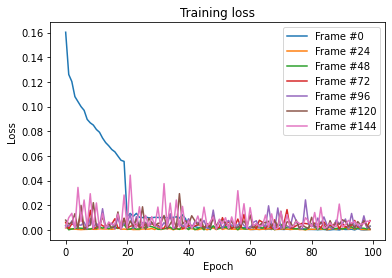

In [29]:
plt.tight_layout()
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

for i, loss in enumerate(loss_all):
    plt.plot(loss, label='Frame #{}'.format(i*skip_size))
plt.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

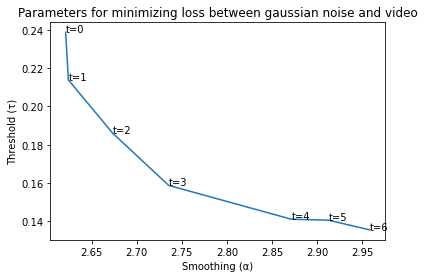

In [30]:
a, t = np.array(params).T
plt.plot(a, t)
for i, (x,y) in enumerate(params):
    plt.annotate('t={}'.format(i), xy=(x,y))
    # plt.annotate('t={}, a,t=({:.02f},{:.02f})'.format(i,x,y), xy=(x,y))
plt.title('Parameters for minimizing loss between gaussian noise and video')
plt.xlabel('Smoothing (α)')
plt.ylabel('Threshold (τ)')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

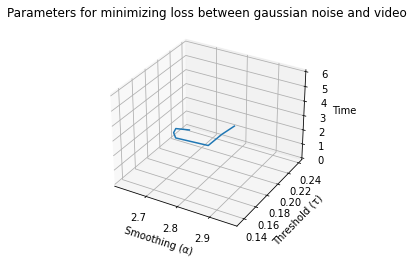

In [31]:
a, t = np.array(params).T
i = np.arange(len(a))

fig = plt.figure()

ax = plt.axes(projection ='3d')
ax.plot(a, t, i)
# for i, (x,y) in enumerate(params):
#     plt.annotate('t={}, a,t=({:.02f},{:.02f})'.format(i,x,y), xy=(x,y))
ax.set_title('Parameters for minimizing loss between gaussian noise and video')
ax.set_xlabel('Smoothing (α)')
ax.set_ylabel('Threshold (τ)')
ax.set_zlabel('Time')
plt.show

In [ ]:
# noise = generate_noise(size, threshold=t[-1], smooth=a[-1])
# F_noise, G_noise = analyse_image(noise, L=L)
# F, G = analyse_image(im[-1], L=L)

# fig, ax = plt.subplots(2,2, figsize=(6,6))
# plt.tight_layout()

# ax[0,0].set_title('Image based off optimized params')
# ax[0,0].imshow(label2rgb(noise))
# ax[1,0].plot(F_noise/G_noise)

# ax[0,1].set_title('Last image in video')
# ax[0,1].imshow(label2rgb(im[-1]))
# ax[1,1].plot(F/G)
# plt.show()

In [32]:
# noise1 = np.mean(generate_noise_array(size, threshold=t[0], smooth=a[0], amount=5), axis=0)
# noise2 = np.mean(generate_noise_array(size, threshold=t[3], smooth=a[3], amount=5), axis=0)
# noise3 = np.mean(generate_noise_array(size, threshold=t[-1], smooth=a[-1], amount=5), axis=0)
noise1 = generate_noise(size, threshold=t[0], smooth=a[0])
noise2 = generate_noise(size, threshold=t[3], smooth=a[3])
noise3 = generate_noise(size, threshold=t[-1], smooth=a[-1])

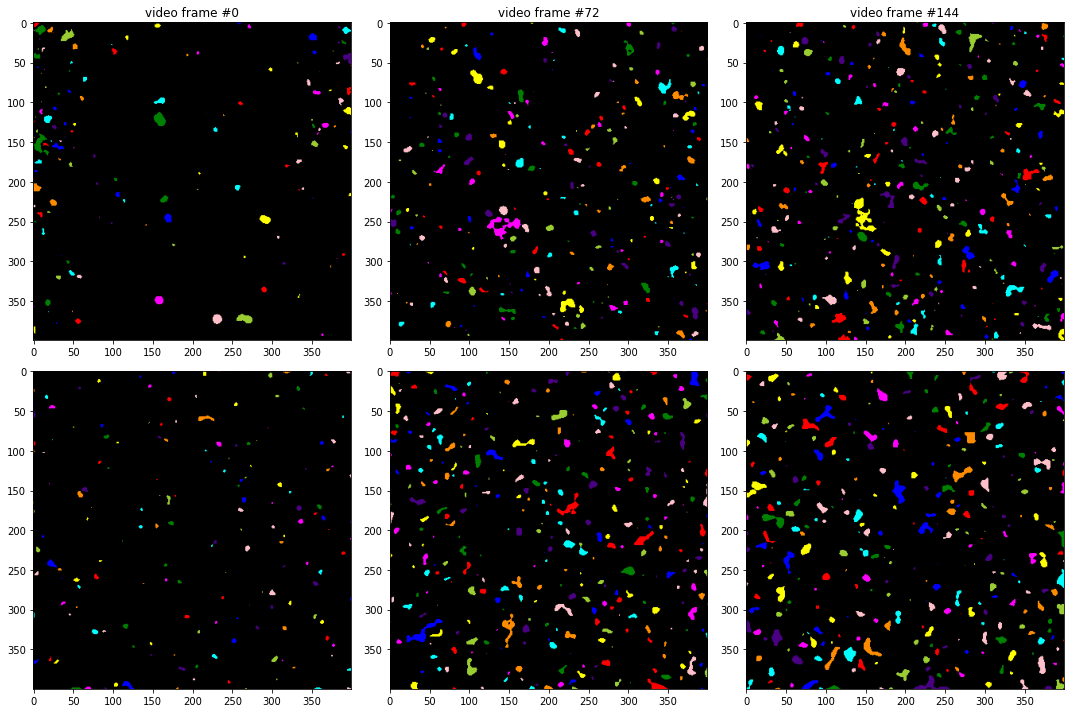

In [33]:
fig, ax = plt.subplots(2,3, figsize=(15,10))

ax[0,0].set_title('video frame #0')
ax[0,0].imshow(label2rgb(im[0]))
ax[0,1].set_title('video frame #72')
ax[0,1].imshow(label2rgb(im[3]))
ax[0,2].set_title('video frame #144')
ax[0,2].imshow(label2rgb(im[-1]))

# ax[1,0].set_title('generated from frame #0')
ax[1,0].imshow(label2rgb(noise1))
# ax[1,1].set_title('generated from frame #72')
ax[1,1].imshow(label2rgb(noise2))
# ax[1,2].set_title('generated from frame #144')
ax[1,2].imshow(label2rgb(noise3))

plt.tight_layout()
# plt.axis('off')
plt.show()

In [34]:
F1, G1 = analyse_image(im[0], L=L)
F2, G2 = analyse_image(im[3], L=L)
F3, G3 = analyse_image(im[-1], L=L)

Fn1, Gn1 = analyse_image(noise1, L=L)
Fn2, Gn2 = analyse_image(noise2, L=L)
Fn3, Gn3 = analyse_image(noise3, L=L)


# Fn1, Gn1 = analyse_video(noise1, L=L)
# Fn2, Gn2 = analyse_video(noise2, L=L)
# Fn3, Gn3 = analyse_video(noise3, L=L)

# Fn1, Gn1 = np.mean(Fn1, axis=0), np.mean(Gn1, axis=0)
# Fn2, Gn2 = np.mean(Fn2, axis=0), np.mean(Gn2, axis=0)
# Fn3, Gn3 = np.mean(Fn3, axis=0), np.mean(Gn3, axis=0)

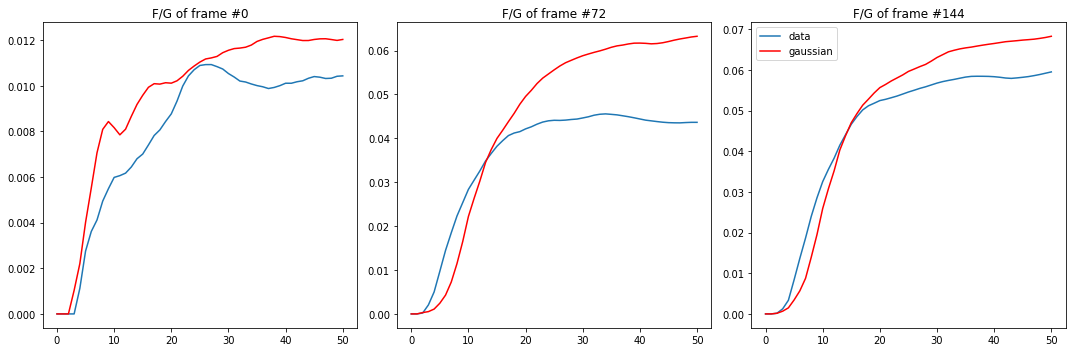

In [35]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

ax[0].set_title('F/G of frame #0')
ax[0].plot(F1/G1, label='data')
ax[0].plot(Fn1/Gn1, label='gaussian', color='red')
ax[1].set_title('F/G of frame #72')
ax[1].plot(F2/G2, label='data')
ax[1].plot(Fn2/Gn2, label='gaussian', color='red')
ax[2].set_title('F/G of frame #144')
ax[2].plot(F3/G3, label='data')
ax[2].plot(Fn3/Gn3, label='gaussian', color='red')

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# def stochastic_loss(thresh, disk):
#     noise = generate_noise(size=size, threshold=thresh, disk_size=disk, amount=4)
#     res_list = stochastic_analyse_video(noise, L=50)
#     return np.mean([(i[0] - y[i[1]])**2 for i in res_list])